# **CONVOLUTIONAL NEURAL NETWORK (CNN)**

## Problem

Train a CNN on the [sign-language dataset](https://www.kaggle.com/datamunge/sign-language-mnist/home).


## Initialize

In [1]:
import cv2
import csv
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Inputs

In [3]:
# input image size
INPUT_SIZE = (28, 28, 3)

# number of classes
NUM_CLASSES = 26

# batch size
BATCH_SIZE = 128

# ratio of validation data to use
VALIDATION_SPLIT = 0.2

**Dataset directories**

- Manually, dowload the dataset from [here](https://www.kaggle.com/datamunge/sign-language-mnist/home).
- Unzip to a folder (`ROOT_DIR`).
- The root folder should contain `sign_mnist_train.csv` and `sign_mnist_test.csv` files.

In [4]:
# root directory
ROO_DIR = '../.tmp/sign-language-mnist'

# train and test csv files
TRAIN_CSV = ROO_DIR + '/sign_mnist_train.csv'
TEST_CSV = ROO_DIR + '/sign_mnist_test.csv'

# directory for log
DIR_LOG = '03-logs'

## Dataset

**Read the dataset**
- The dataset is in `CSV` files.
- Row represnt a sample.
- 1st column is the label (0-26).
- 2nd to 785th column represent pixel values (0-255) in a 28$\times$28 image.

In [5]:
def read_data(filename):
    # read the csv file as pandas dataframe
    df = pd.read_csv(filename, sep=',')

    # the 1st column, header 'label' is the label
    labels = df['label'].to_numpy('int')

    # the remaining 784 columns are 28x28 pixels
    images = df.iloc[:, 1:].to_numpy('float').reshape([-1, 28, 28, 1])

    return images, labels

# read the training and testing dataset
x_train, y_train = read_data(TRAIN_CSV)
x_test, y_test = read_data(TEST_CSV)

# check the shapes
print(f'Train \n    x: {x_train.shape}, y: {y_train.shape}')
print(f'Test \n    x: {x_test.shape}, y: {y_test.shape}')

Train 
    x: (27455, 28, 28, 1), y: (27455,)
Test 
    x: (7172, 28, 28, 1), y: (7172,)


**Dataset splitting**

In [6]:
# number of total and training images
num_total = len(x_train)
num_train = num_total - int(num_total * VALIDATION_SPLIT)

# get randomly shuffled indices
idc = np.arange(num_total)
np.random.shuffle(idc)

# training and validation indices
idc_train = idc[:num_train]
idc_valid = idc[num_train:]

# gathered the dataset from the indices
x_valid = x_train[idc_valid]
y_valid = y_train[idc_valid]

x_train = x_train[idc_train]
y_train = y_train[idc_train]

# check new shapes
print(f'Train \n    x: {x_train.shape}, y: {y_train.shape}')
print(f'Valid \n    x: {x_valid.shape}, y: {y_valid.shape}')
print(f'Test \n    x: {x_test.shape}, y: {y_test.shape}')

Train 
    x: (21964, 28, 28, 1), y: (21964,)
Valid 
    x: (5491, 28, 28, 1), y: (5491,)
Test 
    x: (7172, 28, 28, 1), y: (7172,)


## Data Augmentation

[See tensorflow docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

**Note**
- We perform augmentation only for the training images.
- We normalize all training, validation, and testing images.
- We do not need to shuffle the validation and testing images.

In [7]:
# generate image data with normalization and augmentation
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

# train data generator
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0
)

# generate image data only with normalization
test_datagen = ImageDataGenerator(
    rescale=1 / 255.,
)

# validation data generator
valid_generator = test_datagen.flow(
    x_valid, y_valid,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# test data generator
test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#### Check a few image

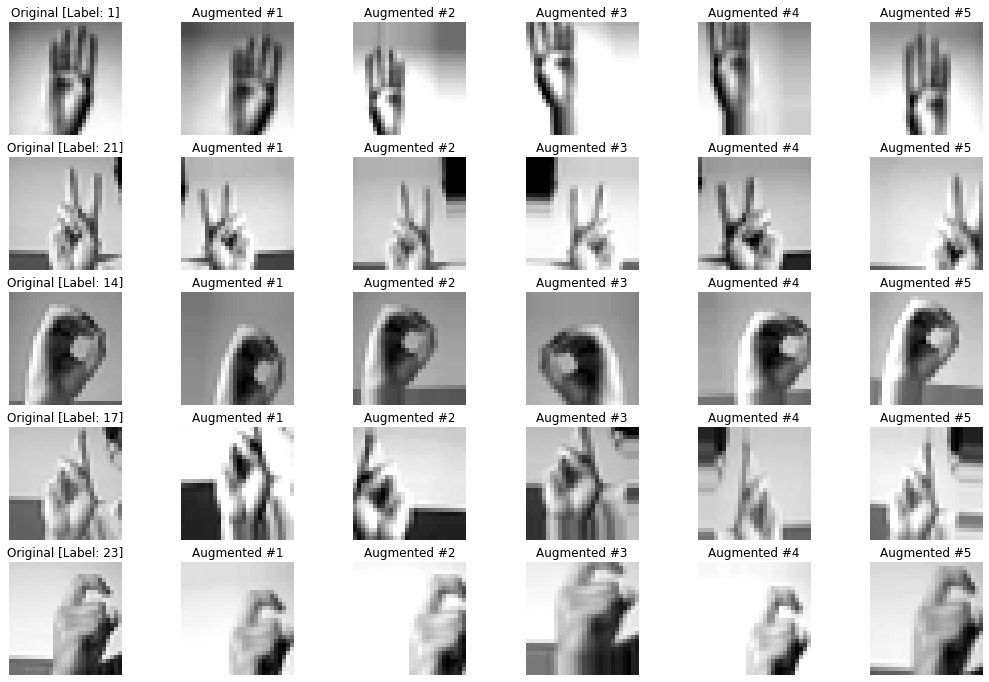

In [8]:
# set subplot numbers
num_rows = 5
num_cols = 6

# get some images
rand_idc = np.random.randint(len(x_train), size=num_rows)
imgs = x_train[rand_idc]
lbls = y_train[rand_idc]

plt.figure(figsize=(18, 12))

for i in range(num_rows):

    # show the original image
    plt.subplot(num_rows, num_cols, i*num_cols + 1)
    plt.title(f'Original [Label: {int(lbls[i])}]')
    plt.axis('off')
    plt.imshow(imgs[i].squeeze(), 'gray')

    # get augmented images
    for j in range(1, num_cols):
        # perform random augmentation
        # NOTE: it performs all random transformation defined in 'train_datagen'
        # except the rescaling
        aug_img = train_datagen.random_transform(imgs[i])

        # convert float to uint8
        aug_img = aug_img.astype('uint8')

        # plot the figures
        plt.subplot(num_rows, num_cols, i*num_cols + j + 1)
        plt.title(f'Augmented #{j}')
        plt.axis('off')
        plt.imshow(aug_img.squeeze(), 'gray')

plt.show()

## Model

**Note**
- The problem is multi-class classification.
- Use `'softmax'` activation function in the output layer.
- Labels are of ordinal category.
- Use `'sparse_categorical_crossentropy'` loss.

In [9]:
# input layer
input_tensor = Input(shape=[28, 28, 1])

# convolution layers
x = Conv2D(16, 3, activation='relu')(input_tensor)
x = MaxPool2D()(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D()(x)

# fully-connected layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# output layer with 'softmax' activation function
output_tensor = Dense(NUM_CLASSES, activation='softmax')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'sparse_categorical_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               102528

## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).


**`ReduceLROnPlateau()`**
- Reduces the learning rate by a factor (defined in `factor`)
if the monitored metric (defined in`monitor`) does not improve
for a number of consecutive eporchs (defined in `patience`).

**`EarlyStopping()`**
- Stops the training if the monitored metric (defined in`monitor`)
does not improve by a defined amount (`min_delta`)
for a number of consecutive eporchs (defined in `patience`).

**`TensorBoard()`**
- Enables tensorboard visualization.
- Launce from commandline: ```tensorboard --logdir=path_to_your_logs```

**Note**
- For metric that needs to be decreasing (e.g., loss), use `mode='min'` or `mode='auto'` (default).
- For metric that needs to be increasing (e.g., accuracy), use `mode='max'`.

In [10]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_acc', mode='max', factor=0.1, patience=3, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_acc',  mode='max', min_delta=0, patience=10, verbose=2, restore_best_weights=True
)

# visualize in tensorboard
tensorboard = TensorBoard(log_dir=DIR_LOG)

# commandline from root directory:
# tensorboard --logdir=02-Computer-Vision/02-logs

## Training

In [11]:
# train the model
hist = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=100,
    verbose=1,
    callbacks=[reduce_rl, early_stopping, tensorboard]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 172 steps, validate for 43 steps
Epoch 1/100
172/172 [==============================] - 8s 49ms/step - loss: 3.0534 - acc: 0.0966 - val_loss: 2.5226 - val_acc: 0.2697
Epoch 2/100
172/172 [==============================] - 7s 41ms/step - loss: 2.4838 - acc: 0.2543 - val_loss: 1.9234 - val_acc: 0.3742
Epoch 3/100
172/172 [==============================] - 7s 41ms/step - loss: 2.0901 - acc: 0.3514 - val_loss: 1.6470 - val_acc: 0.4892
Epoch 4/100
172/172 [==============================] - 7s 41ms/step - loss: 1.8514 - acc: 0.4167 - val_loss: 1.2590 - val_acc: 0.6392
Epoch 5/100
172/172 [==============================] - 7s 41ms/step - loss: 1.6897 - acc: 0.4603 - val_loss: 1.2063 - val_acc: 0.6420
Epoch 6/100
172/172 [==============================] - 7s 41ms/step - loss: 1.5730 - acc: 0.4993 - val_loss: 1.1425 - val_acc: 0.6207
Epoch 7/100
172/172 [==============================] - 7s 42ms/step - loss: 1.4527 - acc: 0.5344 - val_

**Save model**

`model.save()`
- Saves entire model (architecture, weight, and state).
- To load, use `tf.keras.models.load_model()`.

`model.save_weights()`
- Saves only the weights.
- To load, build the model first. Then, `model.load_weights`.

In [12]:
# save the entire model
model.save(DIR_LOG + '/cnn_model.h5', include_optimizer=False)

## Evauation

In [13]:
# get prediction on the test images
y_pred = model.predict(test_generator)

if NUM_CLASSES == 2:
    # for binary classification
    y_pred = y_pred > 0.5
elif NUM_CLASSES > 2:
    # for multi-clas classification
    y_pred = np.argmax(y_pred, axis=1)

**Confusion matrix**

In [14]:
# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

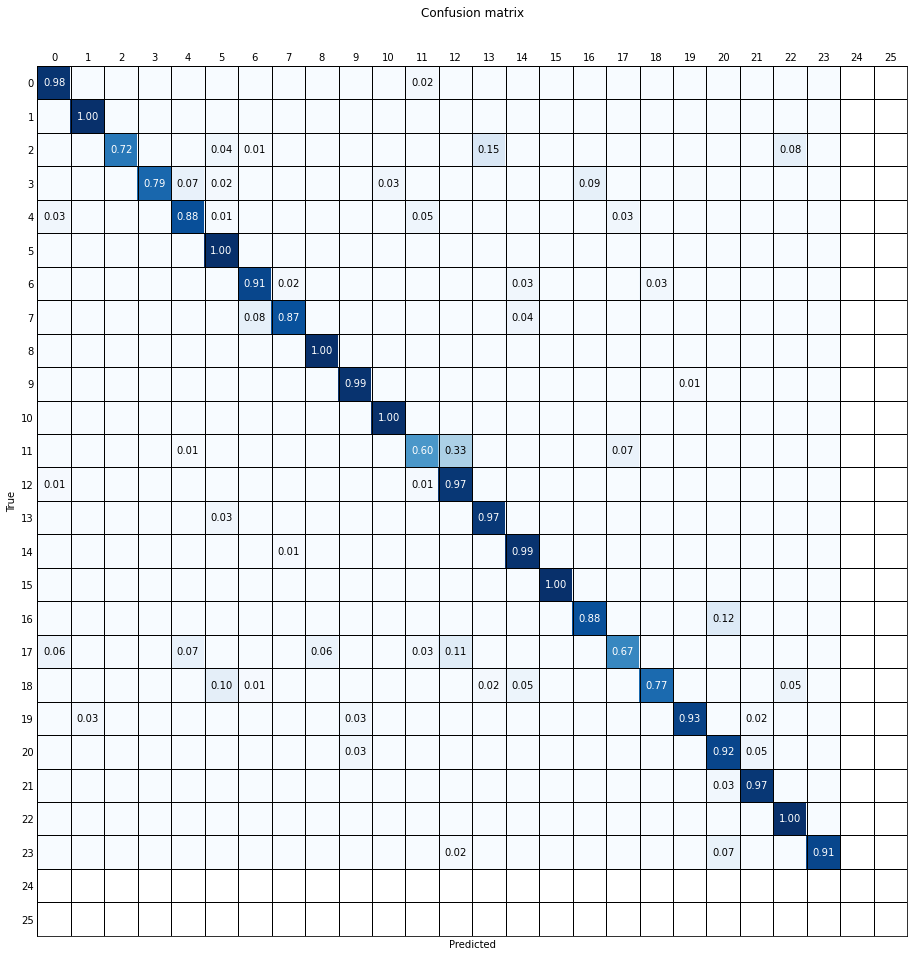

In [15]:
# get name of the classes
labels = list(range(NUM_CLASSES))
# get indices of the classes
indices = list(range(NUM_CLASSES))

# figure for displaying the confusion matrix
fig = plt.figure(figsize=(16, 16))
ax = fig.gca()

# display the confution matrix
cax = ax.matshow(conf_mat, cmap='Blues')

# show the values
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

# title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# show class names
plt.xticks(indices, labels)
plt.yticks(indices, labels)
ax.tick_params(axis='both', which='both', length=0)

# show grid lines
ax.set_xticks(np.arange(-.5, NUM_CLASSES, 1), minor=True)
ax.set_yticks(np.arange(-.5, NUM_CLASSES, 1), minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.show()

**Other metrics**

In [ ]:
# calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

In [17]:
# pandas data frame for storing the metrics
df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
}
)

# calculate the mean
df.loc['(Average)'] = df.mean()

# display
df

,Precision,Recall,F1-score
0,0.905292,0.981873,0.942029
1,0.984055,1.000000,0.991963
2,1.000000,0.722581,0.838951
3,0.989744,0.787755,0.877273
4,0.920168,0.879518,0.899384
5,0.831650,1.000000,0.908088
6,0.885794,0.913793,0.899576
7,0.971867,0.871560,0.918984
8,0.947368,1.000000,0.972973
9,0.942363,0.987915,0.964602
